In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import string
import re

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [4]:
# !pip install pymorphy2

In [6]:
df = pd.read_csv('train.csv')
df.dropna(inplace=True)
df.shape

(926439, 9)

In [11]:
from sklearn.preprocessing import OrdinalEncoder

In [13]:
# import pymorphy2
# morphy = pymorphy2.MorphAnalyzer()

In [14]:
def remove_punctuation(text):
    punc = '!"&\'*,;<=>?[\\]^_`{|}~'
    no_punc = "".join([c for c in text if c not in punc])
    return no_punc

# tokenizer = RegexpTokenizer(r'\w+')
pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''
tokenizer = RegexpTokenizer(pattern)


stopword = ['и', 'в', 'во', 'что', 'он', 'на', 'я', 'с', 'со', 
            'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да',
            'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее',
            'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из',
            'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если',
            'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь',
            'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего',
            'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для',
            'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто',
            'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда',
            'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем',
            'ним', 'здесь', 'этом', 'почти', 'мой', 'тем', 'чтобы', 'нее',
            'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при',
            'наконец', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот',
            'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 
            'эту', 'моя', 'впрочем', 'хорошо', 'свою', 'этой', 'перед', 'иногда',
            'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда',
            'конечно', 'всю', 'между']

def remove_stopwords(text):
    words = [w for w in text if w not in stopword]
    return words

def lemmatize(x):
  result = []
  for i in x:
    result.append(morphy.parse(i)[0].normal_form)
  # print(x)
  return result

def concat_str(x):
    return " ".join([i for i in x])

def text_clean(text):
#     text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # text = re.sub('<.*?>+', '', text) # tags ?
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        # u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        # u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    text = regrex_pattern.sub(r'',text)
#     text = ''.join([i for i in text if not i.isdigit()])
    return text


In [15]:
def preprocessing(df):
    df.datetime_submitted = pd.to_datetime(df['datetime_submitted'])
    df['hour'] = df['datetime_submitted'].dt.hour
    df.description = df.description.apply(lambda x: remove_punctuation(x))
    df.description = df.description.apply(lambda x: tokenizer.tokenize(x.lower()))
    df.description = df.description.apply(lambda x: remove_stopwords(x))
    # df.description = df.description.apply(lambda x: lemmatize(x))
    df.description = df.description.apply(lambda x: concat_str(x))
    df.description = df.description.apply(lambda x: text_clean(x))
    df["descr_len"] = df.description.apply(lambda x: len(x))
    df["descr_count_7"] = df.description.apply(lambda x: x.count("7"))
    df["descr_count_+7"] = df.description.apply(lambda x: x.count("+7"))
    df["title_count_numb"] = df.title.apply(lambda x: len(re.findall(r"\d", x)))
    df["descr_count_numb"] = df.description.apply(lambda x: len(re.findall(r"\d", x)))
    df["title_len"] = df.title.apply(lambda x: len(x))
    regex_phone = r"([8-9]\d{7,10})|(\+7\d{7,10})|((\d.){8,11})|(\+7 \d{3})|(8[(-]\d{3})|(89 )|([8-9] \d)|(\+7\()|(\+7 \()|(\d{2}[(-]\d{2})" #|(\d{2}[(-]\d{2})|([9]\d.{5})"
    regex_mess = r"(inst :)|(instagram :)|(vk :)|(discord :)|(телеграм)|(telegram)|(whats app)|(what's app)|(whatsapp)|(вацап)|(вотсап)|(ватсап)|(ват сап)|(viber)|(вайбер)|(тел :)|(телефон :)|(мтс)|(мегафон)"
    regex_email = r"(http)|(https)|(@mail)|(@gmail)|(@yandex)|(@ya)|(\.com)|(.ru)|(www)" #(\.ru)|(\.ру)
    regex_mobile = r'(\+?[7,8].*\d{3}.*\d{3}.*\d{2}.*\d{2})|([9]\d{2}.*\d{3}.*\d{2}.*\d{2})'
    df["regex_mobile_descr"]  = [1 if i == True else 0 for i in df.description.str.contains(regex_mobile).fillna(False)]
    # email = r"[\w\.-]+@[\w\.-]+(\.[\w]+)"
    df["regex_phone_descr"] = [1 if i == True else 0 for i in df.description.str.contains(regex_phone).fillna(False)]
    df["regex_email_descr"] = [1 if i == True else 0 for i in df.description.str.contains(regex_email).fillna(False)]
    df["regex_mess_descr"]  = [1 if i == True else 0 for i in df.description.str.contains(regex_mess).fillna(False)]
    # df["email_descr"]       = [1 if i == True else 0 for i in df.description.str.contains(email).fillna(False)]
    df["regex_phone_title"] = [1 if i == True else 0 for i in df.title.str.contains(regex_phone).fillna(False)]
    df["regex_email_title"] = [1 if i == True else 0 for i in df.title.str.contains(regex_email).fillna(False)]
    df["regex_mess_title"]  = [1 if i == True else 0 for i in df.title.str.contains(regex_mess).fillna(False)]
    df["messenger"] = (df.regex_phone_descr & df.regex_mess_descr)
    df = df.drop(["title", "datetime_submitted"], axis=1)
    # df['category'] = df['category'].apply(lambda x: hash(x) % 10000007)
    # df['subcategory'] = df['subcategory'].apply(lambda x: hash(x) % 10000007)
    df['region'] = df['region'].apply(lambda x: hash(x) % 10000007)
    df['city'] = df['city'].apply(lambda x: hash(x) % 10000007)
  
    return df

In [17]:
df[df.is_bad==1].head()

,title,description,subcategory,category,price,region,city,datetime_submitted,is_bad
2,Дешёвый буст аккаунтов Dota 4,! Буст аккаунтов с ммр выше 1000ммр не беру ! ...,Предложение услуг,Услуги,200.0,Северная Осетия,Владикавказ,2019-06-01 00:00:50.249692,1
3,Телевизор sharp.Смарт тв.Интернет,Продам телевизор . Диагональ 450.наличие входа...,Аудио и видео,Бытовая электроника,25000.0,Калининградская область,Советск,2019-06-01 00:00:50.325799,1
5,Зимние шины Hankook Winter i*Pike RS6 W569,Размеры шин Hankook Winter i*Pike RS1 W319. Пр...,Запчасти и аксессуары,Транспорт,11000.0,Московская область,Железнодорожный,2019-06-01 00:01:03.471366,1
6,"LADA Priora, 5046",приора 918 норма+кондинционер. 014 машина 16 в...,Автомобили,Транспорт,340000.0,Чеченская Республика,Грозный,2019-06-01 00:01:13.603386,1
10,"Окрашивание элемента 1000,автосервис,сто","АВТОСЕРВИС ""ВИКИНГ""/\n-ОКРАШИВАНИЕ ЭЛЕМЕНТА от...",Предложение услуг,Услуги,1000.0,Россия,Санкт-Петербург,2019-06-01 00:02:35.822686,1


In [19]:
# df.subcategory.value_counts()

In [20]:
%%time
# dff = df.pipe(create_features_and_preproc)
# df = work.iloc[5:8,:]
df = df.pipe(preprocessing)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


CPU times: user 11min 38s, sys: 6.17 s, total: 11min 44s
Wall time: 11min 45s


In [21]:
df.head()

,description,subcategory,category,price,region,city,is_bad,hour,descr_len,descr_count_7,descr_count_+7,title_count_numb,descr_count_numb,title_len,regex_mobile_descr,regex_phone_descr,regex_email_descr,regex_mess_descr,regex_phone_title,regex_email_title,regex_mess_title,messenger
0,продаем диван-кровать . удобный механизм - евр...,Мебель и интерьер,Для дома и дачи,7000.0,777640,5679679,0,0,239,0,0,0,6,13,0,1,0,0,0,0,0,0
1,кожух рулевой колонки daf xf 94 ( 60066004 ) а...,Запчасти и аксессуары,Транспорт,2290.0,777640,5679679,0,0,611,0,0,9,25,39,0,0,0,0,0,0,0,0
2,буст аккаунтов ммр выше 1000ммр не беру отвечу...,Предложение услуг,Услуги,200.0,7126895,5419156,1,0,200,2,0,1,18,29,0,0,0,0,0,0,0,0
3,продам телевизор . диагональ 450 . наличие вхо...,Аудио и видео,Бытовая электроника,25000.0,1694001,3965682,1,0,455,0,0,0,3,33,0,0,0,0,0,0,0,0
4,открытки-конверты ручной работы выполнены техн...,Коллекционирование,Хобби и отдых,150.0,7350129,3420332,0,0,61,0,0,0,0,16,0,0,0,0,0,0,0,0


In [22]:
ordinal_enc = OrdinalEncoder()
# df[['category', 'subcategory', 'region', 'city']] = ordinal_enc.fit_transform(df[['category', 'subcategory', 'region', 'city']])
df[['category', 'subcategory']] = ordinal_enc.fit_transform(df[['category', 'subcategory']])

In [23]:
df.head()

,description,subcategory,category,price,region,city,is_bad,hour,descr_len,descr_count_7,descr_count_+7,title_count_numb,descr_count_numb,title_len,regex_mobile_descr,regex_phone_descr,regex_email_descr,regex_mess_descr,regex_phone_title,regex_email_title,regex_mess_title,messenger
0,продаем диван-кровать . удобный механизм - евр...,24.0,2.0,7000.0,777640,5679679,0,0,239,0,0,0,6,13,0,1,0,0,0,0,0,0
1,кожух рулевой колонки daf xf 94 ( 60066004 ) а...,14.0,7.0,2290.0,777640,5679679,0,0,611,0,0,9,25,39,0,0,0,0,0,0,0,0
2,буст аккаунтов ммр выше 1000ммр не беру отвечу...,36.0,8.0,200.0,7126895,5419156,1,0,200,2,0,1,18,29,0,0,0,0,0,0,0,0
3,продам телевизор . диагональ 450 . наличие вхо...,2.0,0.0,25000.0,1694001,3965682,1,0,455,0,0,0,3,33,0,0,0,0,0,0,0,0
4,открытки-конверты ручной работы выполнены техн...,19.0,9.0,150.0,7350129,3420332,0,0,61,0,0,0,0,16,0,0,0,0,0,0,0,0


In [24]:
df[df.is_bad == 0].description.iloc[2]

'открытки-конверты ручной работы выполнены технике скрапбукинг'

In [26]:
tf_vectorizer = TfidfVectorizer(max_features=700)
# tf_vectorizer = CountVectorizer(max_features=500)

In [27]:
%%time
df_descr_tfidf = tf_vectorizer.fit_transform(df.description)

CPU times: user 1min 15s, sys: 1 s, total: 1min 16s
Wall time: 1min 16s


In [28]:
from sklearn.decomposition import TruncatedSVD
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [29]:
svd = TruncatedSVD(random_state=42, n_components=45)
svd.fit(df_descr_tfidf)

TruncatedSVD(algorithm='randomized', n_components=45, n_iter=5, random_state=42,
             tol=0.0)

([<matplotlib.axis.YTick at 0x7f335d9d1350>,
 <a list of 11 Text major ticklabel objects>)

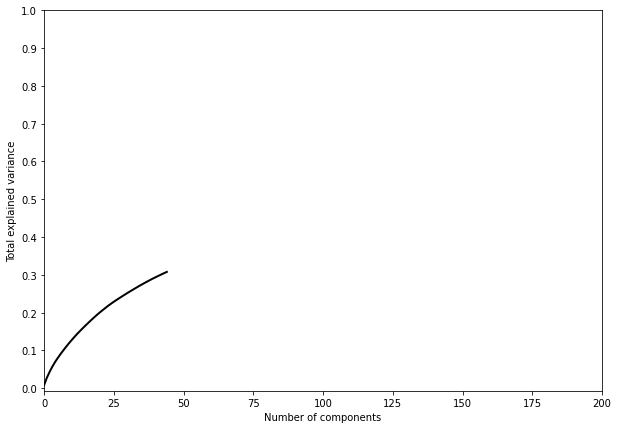

In [31]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum(svd.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))

In [32]:
df_descr_tfidf_svd = pd.DataFrame(svd.transform(df_descr_tfidf), index=df.index)

In [33]:
X = pd.concat([df, df_descr_tfidf_svd], axis=1)

In [34]:
%%time
i = 12
lgm = LGBMClassifier(random_state=42, n_jobs=-1, n_estimators=700, max_depth=i, num_leaves=2**i, boosting_type='gbdt', learning_rate=0.125)
lgm.fit(X.drop(['description', 'is_bad'], axis=1), X['is_bad'])#, sample_weight=X_weights)

CPU times: user 29min 17s, sys: 13.6 s, total: 29min 30s
Wall time: 15min 6s


In [36]:
test_df = pd.read_csv('val.csv')
test_df.dropna(inplace=True)

In [37]:
# test_df = test_df.pipe(create_features_and_preproc)
test_df = test_df.pipe(preprocessing)

/usr/local/lib/python3.7/dist-packages/pandas/core/strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [38]:
# test_df[['category', 'subcategory', 'region', 'city']] = ordinal_enc.transform(test_df[['category', 'subcategory', 'region', 'city']])
test_df[['category', 'subcategory']] = ordinal_enc.transform(test_df[['category', 'subcategory']])

In [39]:
descr_test_tfidf = tf_vectorizer.transform(test_df.description)

In [40]:
descr_test_tfidf_svd = pd.DataFrame(svd.transform(descr_test_tfidf), index=test_df.index)

In [41]:
X_test = pd.concat([test_df, descr_test_tfidf_svd], axis=1)

In [42]:
cats = np.unique(X_test.category.values)

In [44]:
roc = []
for cat in cats:
    tmp = X_test[X_test.category == cat]
    x = tmp.drop(['description', 'is_bad'], axis=1)
    y = tmp.is_bad
    score = roc_auc_score(y, lgm.predict_proba(x)[:,1])
    roc.append(score)
    print(cat, score)

print('mean', sum(roc)/len(roc))

0.0 0.9227284036624204
1.0 0.8914810887239307
2.0 0.9276053702617874
3.0 0.9420479302832244
4.0 0.8538199545391425
5.0 0.9343241855052111
6.0 0.8719327402483136
7.0 0.9814575250125701
8.0 0.8729497594039427
9.0 0.9262551440329218
mean 0.9124602101673466


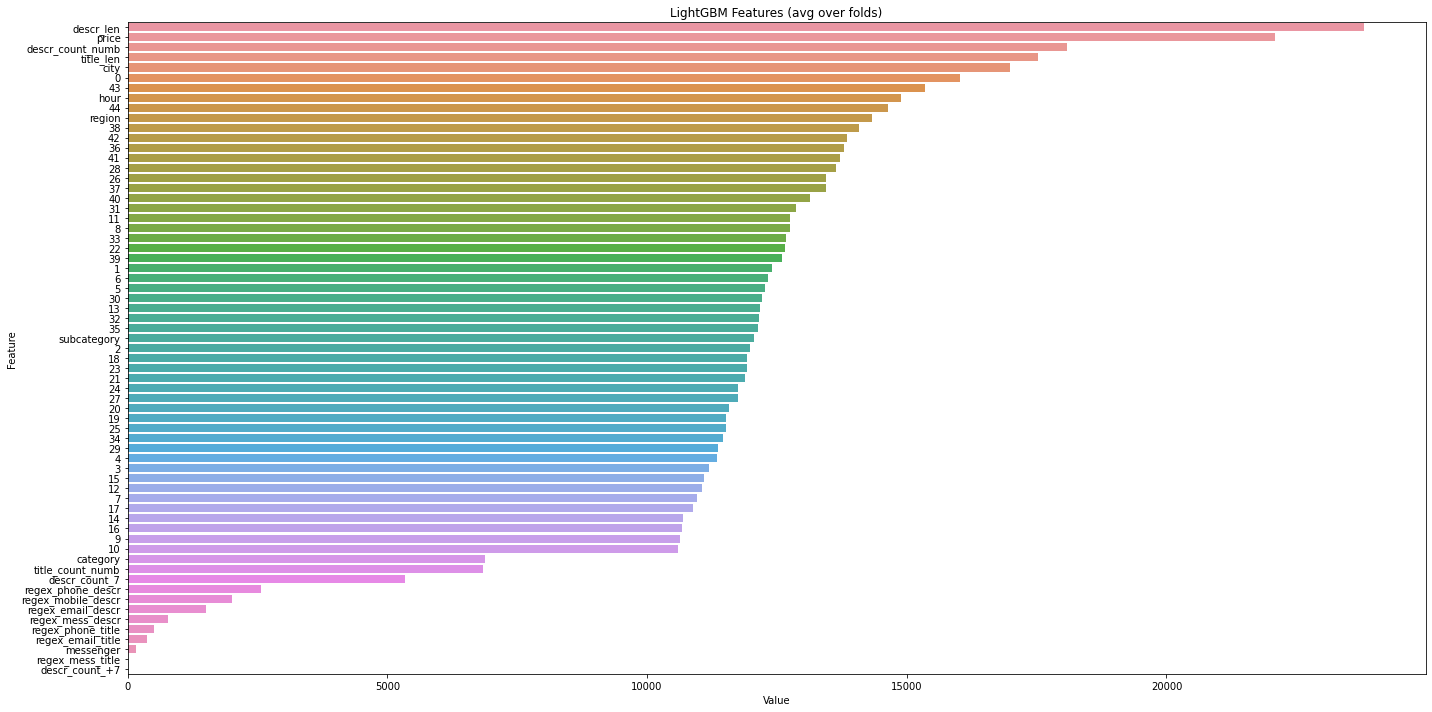

In [45]:
import seaborn as sns
feature_imp = pd.DataFrame(
    sorted(
        zip(
            lgm.feature_importances_, X.drop(['description', 'is_bad'], axis=1).columns
            )
        ), columns=['Value','Feature']
        )

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

### Результат на валидации (среднее по категориям): 0.912460